In [1]:
import argparse, os
from tqdm import tqdm
import torch
import numpy as np
import PIL
from transformers import AutoImageProcessor, DPTForDepthEstimation
import sys
from nsd_access.nsda import NSDAccess
from PIL import Image
import cv2

In [6]:
imgidx = [0,5]
gpu = 0
resolution = 512
nsda = NSDAccess('../Brain-Diffusion/data/nsd')

In [46]:
# Save Directories
os.makedirs(f'../data/nsdfeat/dpt/', exist_ok=True)
for i in range(4):
    os.makedirs(f'../data/nsdfeat/dpt_emb{i}/', exist_ok=True)

In [47]:
image_processor = AutoImageProcessor.from_pretrained("./dpt_large")
model = DPTForDepthEstimation.from_pretrained("./dpt_large")
device = torch.device(f"cuda:{gpu}") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.
Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at ./dpt_large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


DPTForDepthEstimation(
  (dpt): DPTModel(
    (embeddings): DPTViTEmbeddings(
      (patch_embeddings): DPTViTPatchEmbeddings(
        (projection): Conv2d(3, 1024, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): DPTViTEncoder(
      (layer): ModuleList(
        (0-23): 24 x DPTViTLayer(
          (attention): DPTViTAttention(
            (attention): DPTViTSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): DPTViTSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): DPTViTIntermediate(
            

  0%|          | 0/5 [00:00<?, ?it/s]

Now processing image 000000


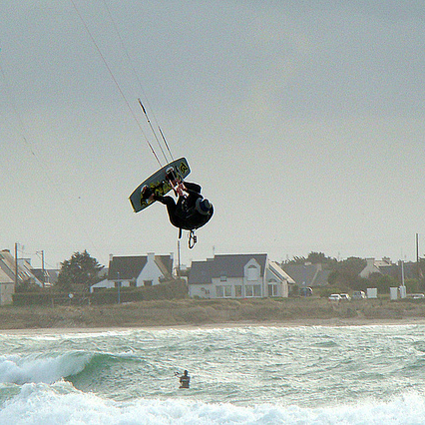

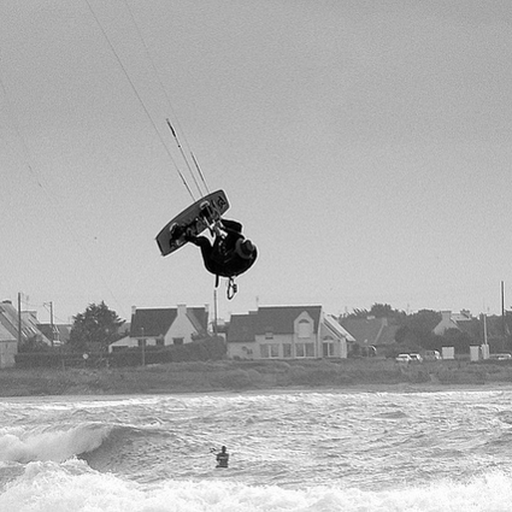

 20%|██        | 1/5 [00:00<00:03,  1.16it/s]

Now processing image 000001


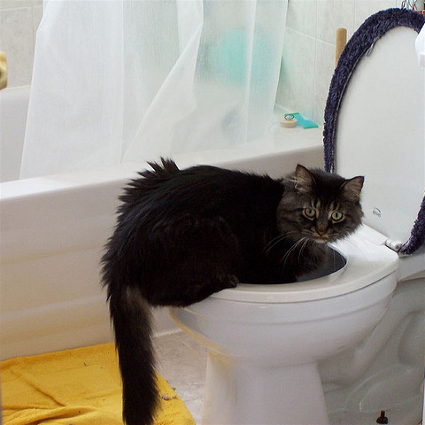

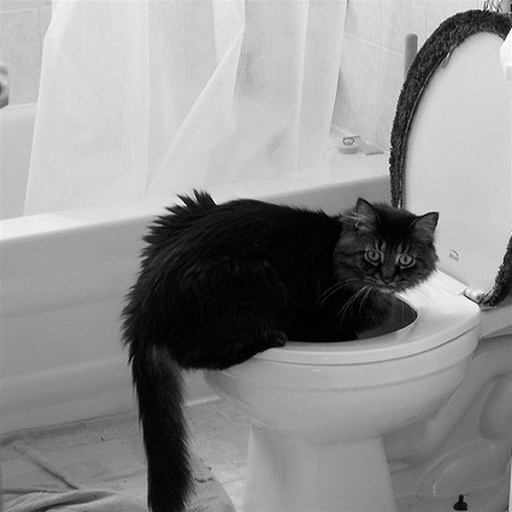

 40%|████      | 2/5 [00:00<00:01,  2.40it/s]

Now processing image 000002


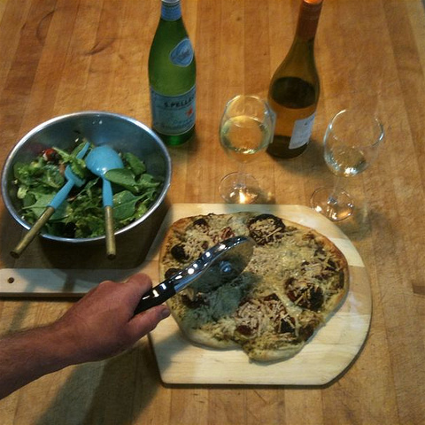

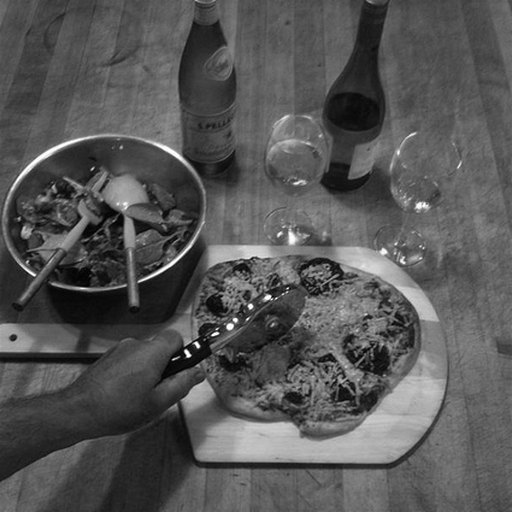

Now processing image 000003


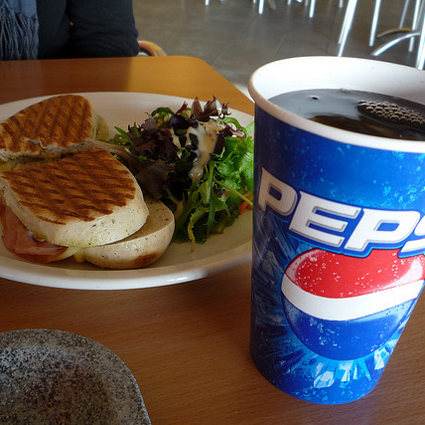

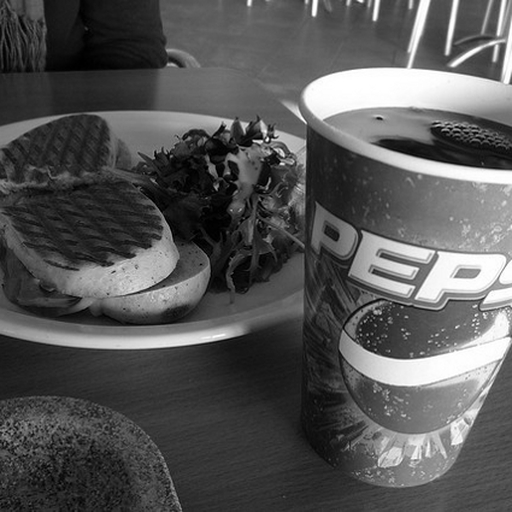

 80%|████████  | 4/5 [00:01<00:00,  4.57it/s]

Now processing image 000004


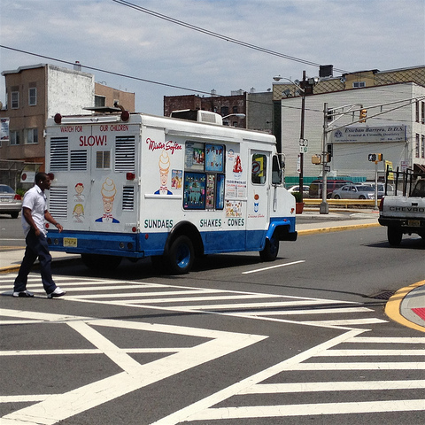

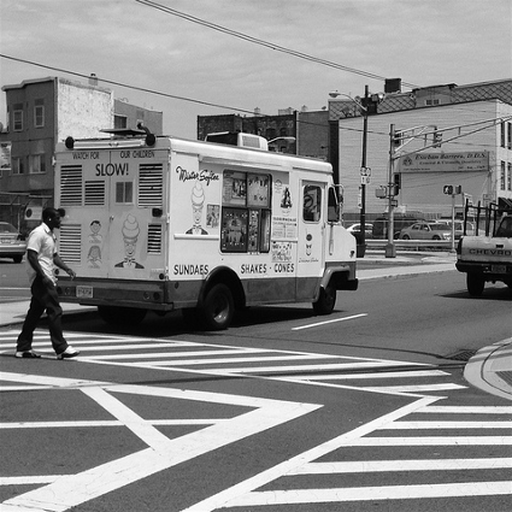

100%|██████████| 5/5 [00:01<00:00,  3.47it/s]


In [7]:
for s in tqdm(range(imgidx[0],imgidx[1])):
    print(f"Now processing image {s:06}")
    img_arr = nsda.read_images(s)
    
    test = Image.fromarray(img_arr)
    test.show()
    
    gray_img = cv2.cvtColor(img_arr, cv2.COLOR_BGR2GRAY)
    
    image = Image.fromarray(gray_img).convert("RGB").resize((resolution, resolution), resample=PIL.Image.LANCZOS)
    image.show()
    # inputs = image_processor(images=image, return_tensors="pt").to(device)
    # with torch.no_grad():
    #     outputs = model(**inputs,output_hidden_states=True)
    #     predicted_depth = outputs.predicted_depth
    # hidden_states = [
    #     feature.to('cpu').detach().numpy() for idx, feature in enumerate(outputs.hidden_states[1:]) if idx in model.config.backbone_out_indices
    #     ]

    # predicted_depth = predicted_depth.to('cpu').detach().numpy()

    # for idx, dpt_idx in enumerate(model.config.backbone_out_indices):
    #     np.save(f'../data/nsdfeat/dpt_emb{idx}/{s:06}.npy',hidden_states[idx])
    # np.save(f'../data/nsdfeat/dpt/{s:06}.npy',predicted_depth)

### 下面将图片转为depth

In [104]:
dpt_embs = np.stack(hidden_states)
dpt_embs = torch.Tensor(dpt_embs).to(device)

In [105]:
dpt_embs.shape

torch.Size([4, 1, 577, 1024])

In [106]:
for s in tqdm(range(dpt_embs.shape[1])):
    hidden_states = [dpt_embs[idx,s,:].reshape(1,577,1024) for idx in range(4)]

100%|██████████| 1/1 [00:00<00:00, 961.33it/s]


In [107]:
with torch.no_grad():
    hidden_states = model.neck(hidden_states)
    predicted_depth = model.head(hidden_states)

In [108]:
# Make depth Image for visual inspection
prediction = torch.nn.functional.interpolate(
    predicted_depth.unsqueeze(1),
    size=(512,512),
    mode="bicubic",
    align_corners=False,
)

# visualize the prediction
output = prediction.squeeze().cpu().numpy()
formatted = (output * 255 / np.max(output)).astype("uint8")
depth = Image.fromarray(formatted)

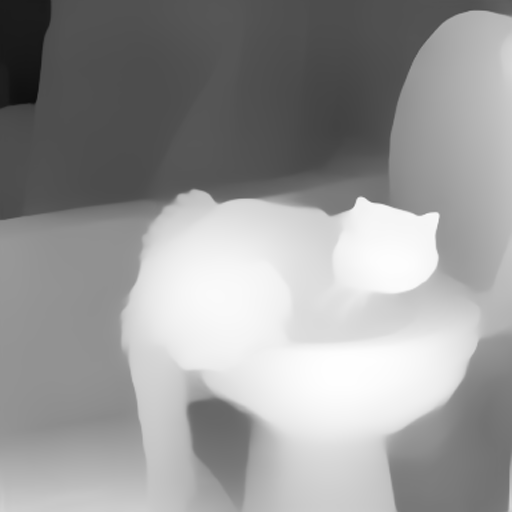

In [109]:
depth.show()